# 의류 분류

- 이진 분류 : sigmoid + binary_crossentropy 출력층 1개
- 다중 분류 : softmax + categorical_crossentropy(class의 값은 원핫 인코딩 값으로 사용해야한다,) 출력층 class개
- 회귀 문제 : mse + mae 출력층 1개

## 데이터 불러오기

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#os.environ을 이용하여 Kaggle API 세팅
os.environ['KAGGLE_USERNAME'] = 'junseokee'
os.environ['KAGGLE_KEY'] = '700d85d8d7f11484367ea21d45aa2bee'

In [3]:
# 데이터 다운로드 하는 명령
!kaggle datasets download -d airplane2230/apparel-image-dataset-2

 99% 246M/249M [00:01<00:00, 227MB/s]
100% 249M/249M [00:01<00:00, 201MB/s]


In [7]:
import os
import zipfile
os.mkdir('/content/csv_data')

In [10]:
with zipfile.ZipFile('/content/apparel-image-dataset-2.zip','r') as existing_zip:
  existing_zip.extractall('/content/csv_data/nocolorinfo')

In [3]:
DATA_PATH = './csv_data/nocolorinfo'

In [4]:
train_df = pd.read_csv(DATA_PATH + '/train.csv')
val_df = pd.read_csv(DATA_PATH + '/val.csv')
test_df = pd.read_csv(DATA_PATH + '/test.csv')

# Colab 에서 사용한다면, 다음 코드 주석을 풀고, 실행시킵니다.
# 또한, colab에서 사용하는 경우 file reading 속도가 매우 느릴 수 있음
train_df['image'] = DATA_PATH + train_df['image'].apply(lambda x: str(x).replace('\\','/')[1:])
val_df['image'] = DATA_PATH + val_df['image'].apply(lambda x: str(x).replace('\\','/')[1:])
test_df['image'] = DATA_PATH + test_df['image'].apply(lambda x: str(x).replace('\\','/')[1:])

del train_df['Unnamed: 0']
train_df.head()

,image,black,blue,brown,green,red,white,dress,shirt,pants,shorts,shoes
0,./csv_data/nocolorinfo/clothes_dataset/blue_sh...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,./csv_data/nocolorinfo/clothes_dataset/red_pan...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,./csv_data/nocolorinfo/clothes_dataset/green_p...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,./csv_data/nocolorinfo/clothes_dataset/brown_s...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,./csv_data/nocolorinfo/clothes_dataset/white_d...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


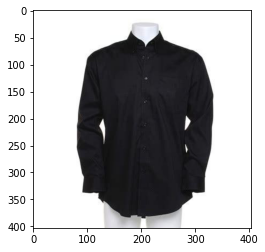

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread(train_df.iloc[6]['image'])
plt.imshow(img)

In [6]:
import numpy as np
from PIL import Image
img = Image.open(train_df.iloc[1]['image'])
imgArray = np.array(img)
print(imgArray.shape)

(756, 474, 3)


## 이미지 제너레이터 정의

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#이미지 제너레이터 정의
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

## 모델정의

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()

model.add(Flatten(input_shape = (112, 112, 3)))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(11, activation = 'sigmoid'))

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])


## 데이터 제너레이터 정의

In [13]:
batch_size = 32
class_col = ['black','blue','brown','green','red','white','dress','shirt','pants','shorts','shoes']

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory=None,
    x_col = 'image',
    y_col = class_col,
    target_size = (112, 112),
    color_mode = 'rgb',
    class_mode = 'raw',
    batch_size = batch_size,
    shuffle = True,
    seed = 42
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='',
    x_col = 'image',
    y_col = class_col,
    target_size = (112, 112),
    color_mode = 'rgb',
    class_mode = 'raw',
    batch_size = batch_size,
    shuffle = True
)

Found 5578 validated image filenames.
Found 2391 validated image filenames.


In [14]:
def get_steps(num_samples, batch_size):
  if (num_samples % batch_size) > 0 :
    return (num_samples // batch_size) + 1
  else:
    return num_samples // batch_size

In [15]:
history = model.fit(train_generator,
                    steps_per_epoch = get_steps(len(train_df), batch_size),
                    validation_data = val_generator,
                    validation_steps = get_steps(len(val_df), batch_size),
                    epochs = 10)

Epoch 1/10
175/175 [==============================] - 38s 207ms/step - loss: 0.5278 - acc: 0.3584 - val_loss: 0.3469 - val_acc: 0.3509
Epoch 2/10
175/175 [==============================] - 37s 211ms/step - loss: 0.2984 - acc: 0.4643 - val_loss: 0.3196 - val_acc: 0.4333
Epoch 3/10
175/175 [==============================] - 39s 223ms/step - loss: 0.2490 - acc: 0.5136 - val_loss: 0.2350 - val_acc: 0.5119
Epoch 4/10
175/175 [==============================] - 36s 208ms/step - loss: 0.2329 - acc: 0.5319 - val_loss: 0.2277 - val_acc: 0.5839
Epoch 5/10
175/175 [==============================] - 37s 212ms/step - loss: 0.2019 - acc: 0.5387 - val_loss: 0.2105 - val_acc: 0.6324
Epoch 6/10
175/175 [==============================] - 36s 205ms/step - loss: 0.1879 - acc: 0.5523 - val_loss: 0.2096 - val_acc: 0.6637
Epoch 7/10
175/175 [==============================] - 37s 211ms/step - loss: 0.1784 - acc: 0.5676 - val_loss: 0.1948 - val_acc: 0.5684
Epoch 8/10
175/175 [==============================] - 3

In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory=None,
    x_col = 'image',
    y_col = None,
    target_size = (112, 112),
    color_mode = 'rgb',
    class_mode = None,
    batch_size = batch_size,
    shuffle = False
)

Found 3416 validated image filenames.


In [19]:
preds = model.predict(test_generator,
                      steps = get_steps(len(test_df),batch_size),
                                        verbose = 1)

107/107 [==============================] - 20s 184ms/step


In [20]:
preds.shape

(3416, 11)

In [21]:
prob = zip(class_col, list(preds[1]))
prob

In [22]:
sorted(list(prob), key = lambda z: z[1], reverse = True)

[('pants', 0.99944735),
 ('black', 0.7823058),
 ('brown', 0.61686563),
 ('shorts', 0.0076804757),
 ('green', 0.006539762),
 ('blue', 0.005391538),
 ('shoes', 0.0008378923),
 ('shirt', 0.00057443976),
 ('red', 0.0003271103),
 ('dress', 2.0207017e-05),
 ('white', 4.1530447e-07)]

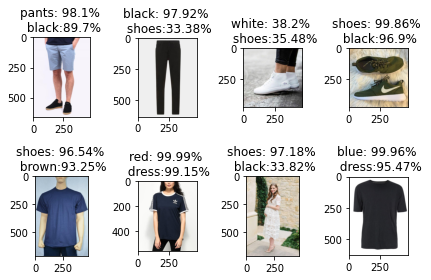

In [28]:
import matplotlib.pyplot as plt
import cv2 #실시간 이미지 프로세싱에 중점을 둔 ㅇ라이브러리이다.

do_preds = preds[:8]
for i, pred in enumerate(do_preds):
  plt.subplot(2,4,i+1)
  prob = zip(class_col, list(pred))
  prob = sorted(list(prob), key=lambda z: z[1], reverse = True)[:2]

  image = cv2.imread(test_df['image'][i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.imshow(image)
  plt.title(f'{prob[0][0]}: {round(prob[0][1] * 100, 2)}% \n {prob[1][0]}:{round(prob[1][1] * 100, 2)}%')

plt.tight_layout()

- 이진 분류 : sigmoid + binary_crossentropy 출력층 1개
- 다중 분류 : softmax + categorical_crossentropy(class의 값은 원핫 인코딩 값으로 사용해야한다,) 출력층 class개
- 회귀 문제 : mse + mae 출력층 1개